# Basic Statistics for Cosmology: Exercises on $H_0$

This notebook is designed as a **student exercise**.  
You will work through **Frequentist** and **Bayesian** methods to estimate the Hubble constant $H_0$ from mock data.  

👉 This is the **exercise version** (without solutions).  
The instructor has a separate notebook with solutions.

---

## Instructions
- Fill in the code cells where you see `# TODO`.
- Answer the discussion questions in markdown cells.
- Try to first attempt on your own before checking solutions.

---

## Doing SN cosmology with a synthetic dataset, using luminosity distance relation

**Key low-$z$ relations** (valid for $z\lesssim0.1$):

$$ d_L \approx \frac{cz}{H_0} \quad (\text{in Mpc}) $$
$$ \mu \equiv m - M = 5\log_{10}\!\left( \frac{d_L}{\text{Mpc}} \right) + 25 $$
Combining these: 
$$ m = M + 5\log_{10}(cz) - 5\log_{10}(H_0) + 25. $$

If $M$ is known (from external calibration), one can directly infer $H_0$. If $M$ is unknown **and** you only fit SN data, then $(M, H_0)$ are nearly perfectly degenerate at low $z$—you must supply an $M$ prior or external constraint to break the degeneracy.



## Part 1: Frequentist Statistics

### Exercise 1.1: Load and Visualize Data
Generate a very simplistic SN dataset!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

c_km_s = 299792.458  # speed of light in km/s

def mu_from_z(z, H0):
    """Low-z luminosity distance modulus: mu = 5 log10(c z / H0 [Mpc]) + 25.
    Here c is in km/s, H0 in km/s/Mpc, so cz/H0 is in Mpc.
    """
    dL_Mpc = (c_km_s * z) / H0
    return 5.0 * np.log10(dL_Mpc) + 25.0

def mag_model(z, H0, M):
    return M + mu_from_z(z, H0)

def sigma_mu_pec(z, v_pec=300.0, H0=70.0):
    """Approximate magnitude uncertainty from peculiar velocities.
    sigma_mu ~ (5/ln(10)) * (sigma_dL/dL).
    At low z, dL ~ cz/H0, so fractional distance error from peculiar velocity sigma_v is ~ sigma_v/(cz).
    """
    frac = v_pec/(c_km_s * z)
    return (5/np.log(10)) * frac

@dataclass
class SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    z : np.ndarray
        Array of redshifts of the supernovae.
    m : np.ndarray
        Array of observed magnitudes of the supernovae.
    sigma_m : np.ndarray
        Array of total magnitude uncertainties (measurement + intrinsic + peculiar velocity).
    name : str
        Str for the name of the sample (default is "synthetic").
    """
    z: np.ndarray
    m: np.ndarray
    sigma_m: np.ndarray
    name: str = "synthetic"

def make_synthetic_sample(N=100, H0=73.0, M=-19.3, zmin=0.01, zmax=0.08,
                          sigma_meas=0.1, sigma_int=0.1, v_pec=300.0, rng=None) -> SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    N : int
        Number of supernovae to simulate.
    H0 : float
        True Hubble constant (km/s/Mpc) used to generate the data.
    M : float
        True absolute magnitude of the supernovae.
    zmin : float
        Minimum redshift of the sample.
    zmax : float
        Maximum redshift of the sample.
    sigma_meas : float
        Measurement uncertainty in magnitudes (per SN).
    sigma_int : float
        Intrinsic scatter in magnitudes (per SN).
    v_pec : float
        RMS peculiar velocity in km/s (affects low-z distance errors).
    rng : int, np.random.Generator, or None
        Random seed or numpy random generator for reproducibility.

    Returns
    -------
    SNSample
        Dataclass containing arrays of redshift (z), observed magnitude (m), 
        total magnitude uncertainty (sigma_m), and sample name.
    """
    rng = np.random.default_rng(rng)
    z = np.sort(rng.uniform(zmin, zmax, size=N))
    mu = mu_from_z(z, H0)
    m_true = M + mu
    # per-SN error budget: measurement + peculiar velocity + intrinsic scatter
    sig_pec = sigma_mu_pec(z, v_pec=v_pec, H0=H0)
    sigma_tot = np.sqrt(sigma_meas**2 + sig_pec**2 + sigma_int**2)
    m_obs = rng.normal(m_true, sigma_tot)
    return SNSample(z=z, m=m_obs, sigma_m=sigma_tot, name="synthetic")

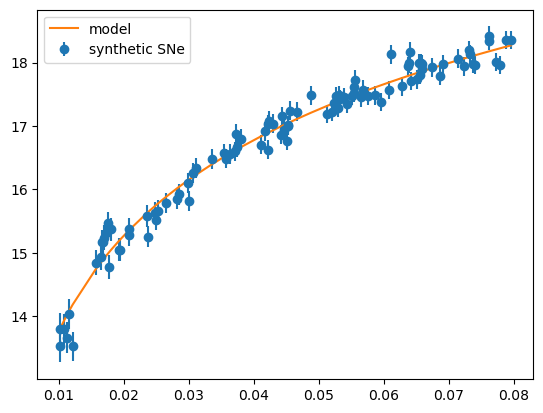

In [15]:
# TODO: generate and plot data with error bars
synth_samp = make_synthetic_sample()
plt.errorbar(synth_samp.z, synth_samp.m, synth_samp.sigma_m, fmt = 'o', label = 'synthetic SNe')
plt.plot(synth_samp.z, mag_model(synth_samp.z, 73.0, -19.3), label = 'model')
plt.legend()

### Exercise 1.2: Define the χ² function
Write down the chi-square function for the model.

In [53]:
# TODO: define chi2 function
def chi2(theta, x, y, sigma):
    return np.sum( ((y - mag_model(x, *theta))/sigma)**2 )

### Exercise 1.3: Minimize χ²
Find the best-fit parameters by minimizing χ².

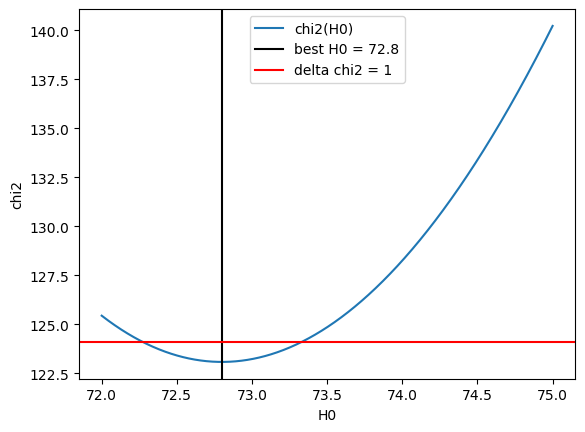

In [54]:
# TODO: use numpy or scipy to minimize chi2

M=-19.3
H0= np.linspace(72,75,1000)

chi2_list = [chi2([h,M], synth_samp.z, synth_samp.m, synth_samp.sigma_m) for h in H0]

plt.plot(H0, chi2_list, label='chi2(H0)')
idx_min_chi2 = np.argmin(chi2_list)
min_chi2 = chi2_list[idx_min_chi2]
best_H0 = H0[idx_min_chi2]
plt.axvline(best_H0, color='black', label = f'best H0 = {best_H0:.4g}')
plt.axhline(min_chi2 + 1, color = 'red', label = 'delta chi2 = 1')
plt.ylabel('chi2')
plt.xlabel('H0')
plt.legend()

In [ ]:
# TODO: say something about goodness of fit

Text(0, 0.5, 'residuals')

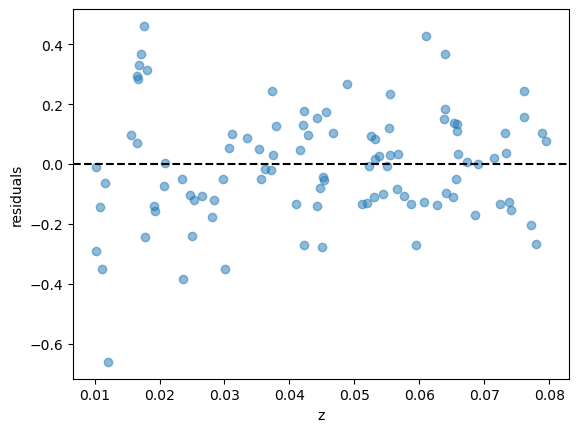

In [50]:
# TODO: plot residuals, always!

res = synth_samp.m - mag_model(synth_samp.z, best_H0, M)
plt.plot(synth_samp.z, res, 'o', alpha = 0.5)
plt.axhline(0, linestyle = '--', color='black')
plt.xlabel('z')
plt.ylabel('residuals')

### Exercise 1.4: Bootstrap uncertainties
Use bootstrap resampling to estimate parameter uncertainties.

In [ ]:
# TODO: implement bootstrap loop, any ideas how to do this?

# The concept is to resample the data with replacement, fit each resampled dataset, and collect the best-fit parameters to estimate uncertainties.

### Exercise 1.5: p-value
Calculate a p-value from the sampled probability

In [ ]:
# TODO: let's calculate a p-value from the sampled probability

### Exercise 1.6: Compare with MLE
Explain how minimizing χ² relates to Maximum Likelihood Estimation.

👉 *Write your discussion here*

## Part 2: Bayesian Statistics

### Exercise 2.1: Bayes' theorem
Write Bayes' theorem and identify prior, likelihood, posterior.

👉 *Write Bayes' theorem in your own words here*

### Exercise 2.2: Compute Posterior on a Grid
Define priors and likelihood, then compute posterior on a parameter grid.

In [ ]:
# TODO: implement grid posterior evaluation

### Exercise 2.3: Normalize Posterior and Extract Marginal Estimates
Normalize posterior, compute marginal estimations of $H_0$ and $M$

In [1]:
# TODO: normalize posterior
# TODO: compute marginal distributions

### Exercise 2.4: Credible Interval
Compute the 68% credible interval from the posterior.

In [ ]:
# TODO: credible interval calculation

### Exercise 2.5: Compare with Frequentist Result
Compare Bayesian and Frequentist estimates of $H_0$.

👉 *Write your comparison here*

## Part 3: Re-do with `Cobaya`

Estimate $H_0$ using Cobaya and Bayesian Statistics and compare